# Transformer

## Building a Transformer with PyTorch

To build the Transformer model the following steps are necessary:

1. Importing the libraries and modules
2. Defining the basic building blocks - Multi-head Attention, Position-Wise Feed-Forward Networks, Positional Encoding
3. Building the Encoder block
4. Building the Decoder block
5. Combining the Encoder and Decoder layers to create the complete Transformer network

### 1. Importing the necessary libraries and modules

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import math
import copy

### 2. Defining the basic building blocks: Multi-Head Attention, Position-wise Feed-Forward Networks, Positional Encoding
#### Multi-head Attention
The Multi-Head Attention mechanism computes the attention between each pair of positions in a sequence. It consists of multiple “attention heads” that capture different aspects of the input sequence.

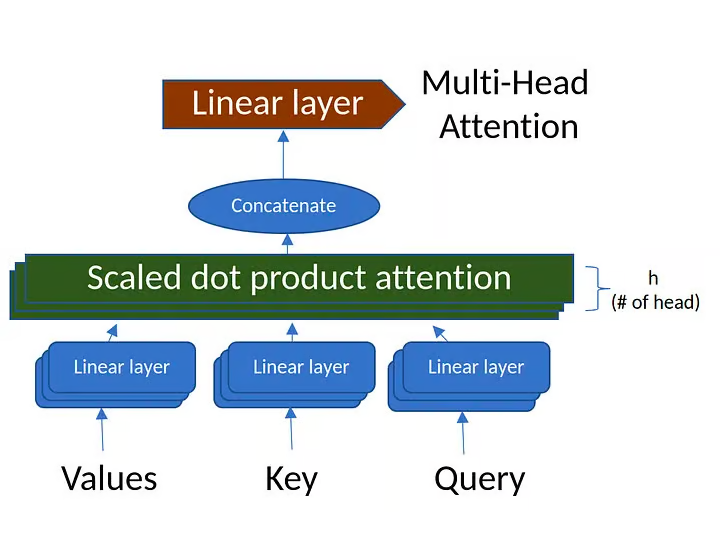

In [2]:
class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        # Ensure that the model dimension (d_model) is divisible by the number of heads
        assert d_model % num_heads == 0, "d_model must be divisible by num_heads"
        
        # Initialize dimensions
        self.d_model = d_model # Model's dimension
        self.num_heads = num_heads # Number of attention heads
        self.d_k = d_model // num_heads # Dimension of each head's key, query, and value
        
        # Linear layers for transforming inputs
        self.W_q = nn.Linear(d_model, d_model) # Query transformation
        self.W_k = nn.Linear(d_model, d_model) # Key transformation
        self.W_v = nn.Linear(d_model, d_model) # Value transformation
        self.W_o = nn.Linear(d_model, d_model) # Output transformation
        
    def scaled_dot_product_attention(self, Q, K, V, mask=None):
        # Calculate attention scores
        attn_scores = torch.matmul(Q, K.transpose(-2, -1)) / math.sqrt(self.d_k)
        
        # Apply mask if provided (useful for preventing attention to certain parts like padding)
        if mask is not None:
            attn_scores = attn_scores.masked_fill(mask == 0, -1e9)
        
        # Softmax is applied to obtain attention probabilities
        attn_probs = torch.softmax(attn_scores, dim=-1)
        
        # Multiply by values to obtain the final output
        output = torch.matmul(attn_probs, V)
        return output
        
    def split_heads(self, x):
        # Reshape the input to have num_heads for multi-head attention
        batch_size, seq_length, d_model = x.size()
        return x.view(batch_size, seq_length, self.num_heads, self.d_k).transpose(1, 2)
        
    def combine_heads(self, x):
        # Combine the multiple heads back to original shape
        batch_size, _, seq_length, d_k = x.size()
        return x.transpose(1, 2).contiguous().view(batch_size, seq_length, self.d_model)
        
    def forward(self, Q, K, V, mask=None):
        # Apply linear transformations and split heads
        Q = self.split_heads(self.W_q(Q))
        K = self.split_heads(self.W_k(K))
        V = self.split_heads(self.W_v(V))
        
        # Perform scaled dot-product attention
        attn_output = self.scaled_dot_product_attention(Q, K, V, mask)
        
        # Combine heads and apply output transformation
        output = self.W_o(self.combine_heads(attn_output))
        return output

#### Position-wise Feed-Forward Networks

In [3]:
class PositionWiseFeedForward(nn.Module):
    def __init__(self, d_model, d_ff):
        super(PositionWiseFeedForward, self).__init__()
        self.fc1 = nn.Linear(d_model, d_ff)
        self.fc2 = nn.Linear(d_ff, d_model)
        self.relu = nn.ReLU()

    def forward(self, x):
        return self.fc2(self.relu(self.fc1(x)))

#### Positional Encoding

In [4]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_seq_length):
        super(PositionalEncoding, self).__init__()
        
        pe = torch.zeros(max_seq_length, d_model)
        position = torch.arange(0, max_seq_length, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * -(math.log(10000.0) / d_model))
        
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        
        self.register_buffer('pe', pe.unsqueeze(0))
        
    def forward(self, x):
        return x + self.pe[:, :x.size(1)]

### 3. Building the Encoder Blocks

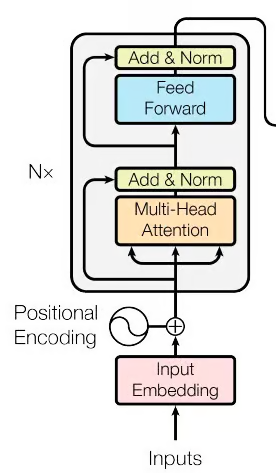

In [5]:
class EncoderLayer(nn.Module):
    def __init__(self, d_model, num_heads, d_ff, dropout):
        super(EncoderLayer, self).__init__()
        self.self_attn = MultiHeadAttention(d_model, num_heads)
        self.feed_forward = PositionWiseFeedForward(d_model, d_ff)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x, mask):
        attn_output = self.self_attn(x, x, x, mask)
        x = self.norm1(x + self.dropout(attn_output))
        ff_output = self.feed_forward(x)
        x = self.norm2(x + self.dropout(ff_output))
        return x

### 4. Building the Decoder Blocks

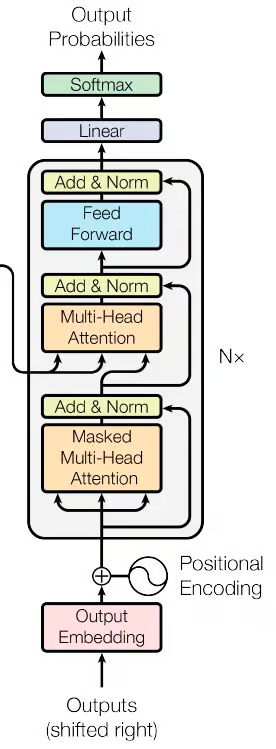

In [6]:
class DecoderLayer(nn.Module):
    def __init__(self, d_model, num_heads, d_ff, dropout):
        super(DecoderLayer, self).__init__()
        self.self_attn = MultiHeadAttention(d_model, num_heads)
        self.cross_attn = MultiHeadAttention(d_model, num_heads)
        self.feed_forward = PositionWiseFeedForward(d_model, d_ff)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.norm3 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x, enc_output, src_mask, tgt_mask):
        attn_output = self.self_attn(x, x, x, tgt_mask)
        x = self.norm1(x + self.dropout(attn_output))
        attn_output = self.cross_attn(x, enc_output, enc_output, src_mask)
        x = self.norm2(x + self.dropout(attn_output))
        ff_output = self.feed_forward(x)
        x = self.norm3(x + self.dropout(ff_output))
        return x

### 5. Combining the Encoder and Decoder layers to create the complete Transformer network

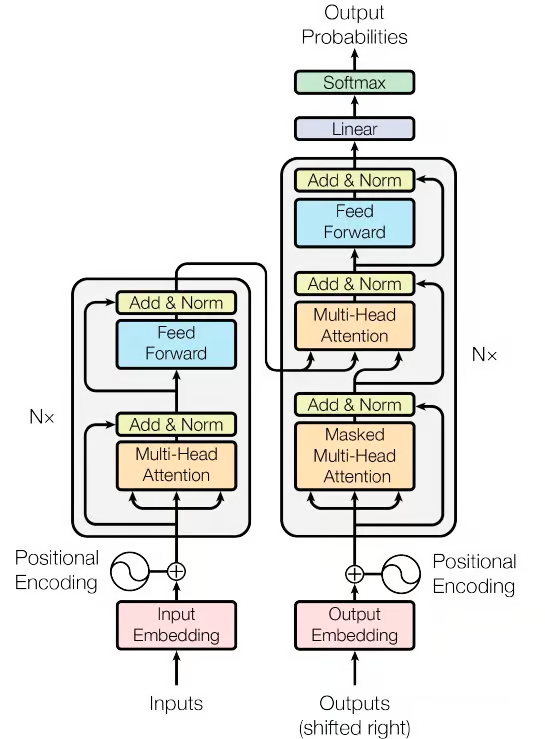

In [7]:
class Transformer(nn.Module):
    def __init__(self, src_vocab_size, tgt_vocab_size, d_model, num_heads, num_layers, d_ff, max_seq_length, dropout):
        super(Transformer, self).__init__()
        self.encoder_embedding = nn.Embedding(src_vocab_size, d_model)
        self.decoder_embedding = nn.Embedding(tgt_vocab_size, d_model)
        self.positional_encoding = PositionalEncoding(d_model, max_seq_length)

        self.encoder_layers = nn.ModuleList([EncoderLayer(d_model, num_heads, d_ff, dropout) for _ in range(num_layers)])
        self.decoder_layers = nn.ModuleList([DecoderLayer(d_model, num_heads, d_ff, dropout) for _ in range(num_layers)])

        self.fc = nn.Linear(d_model, tgt_vocab_size)
        self.dropout = nn.Dropout(dropout)

    def generate_mask(self, src, tgt):
        src_mask = (src != 0).unsqueeze(1).unsqueeze(2)
        tgt_mask = (tgt != 0).unsqueeze(1).unsqueeze(3)
        seq_length = tgt.size(1)
        nopeak_mask = (1 - torch.triu(torch.ones(1, seq_length, seq_length), diagonal=1)).bool()
        tgt_mask = tgt_mask & nopeak_mask
        return src_mask, tgt_mask

    def forward(self, src, tgt):
        src_mask, tgt_mask = self.generate_mask(src, tgt)
        src_embedded = self.dropout(self.positional_encoding(self.encoder_embedding(src)))
        tgt_embedded = self.dropout(self.positional_encoding(self.decoder_embedding(tgt)))

        enc_output = src_embedded
        for enc_layer in self.encoder_layers:
            enc_output = enc_layer(enc_output, src_mask)

        dec_output = tgt_embedded
        for dec_layer in self.decoder_layers:
            dec_output = dec_layer(dec_output, enc_output, src_mask, tgt_mask)

        output = self.fc(dec_output)
        return output

## Training the PyTorch Transformer Model

For illustrative purposes, a dummy dataset will be crafted in this example. However, in a practical scenario, a more substantial dataset would be employed, and the process would involve text preprocessing along with the creation of vocabulary mappings for both the source and target languages.

Hyperparameters:

These values define the architecture and behavior of the transformer model:

1. `src_vocab_size`, `tgt_vocab_size`: Vocabulary sizes for source and target sequences, both set to 5000.
2. `d_model`: Dimensionality of the model's embeddings, set to 512.
3. `num_heads`: Number of attention heads in the multi-head attention mechanism, set to 8.
4. `num_layers`: Number of layers for both the encoder and the decoder, set to 6.
5. `d_ff`: Dimensionality of the inner layer in the feed-forward network, set to 2048.
6. `max_seq_length`: Maximum sequence length for positional encoding, set to 100.
7. `dropout`: Dropout rate for regularization, set to 0.1.

In [8]:
src_vocab_size = 5000
tgt_vocab_size = 5000
d_model = 512
num_heads = 8
num_layers = 6
d_ff = 2048
max_seq_length = 100
dropout = 0.1

transformer = Transformer(src_vocab_size, tgt_vocab_size, d_model, num_heads, num_layers, d_ff, max_seq_length, dropout)

# Generate random sample data
src_data = torch.randint(1, src_vocab_size, (64, max_seq_length))  # (batch_size, seq_length)
tgt_data = torch.randint(1, tgt_vocab_size, (64, max_seq_length))  # (batch_size, seq_length)

## Training the Model

In [9]:
criterion = nn.CrossEntropyLoss(ignore_index=0)
optimizer = optim.Adam(transformer.parameters(), lr=0.0001, betas=(0.9, 0.98), eps=1e-9)

transformer.train()

for epoch in range(100):
    optimizer.zero_grad()
    output = transformer(src_data, tgt_data[:, :-1])
    loss = criterion(output.contiguous().view(-1, tgt_vocab_size), tgt_data[:, 1:].contiguous().view(-1))
    loss.backward()
    optimizer.step()
    print(f"Epoch: {epoch+1}, Loss: {loss.item()}")

Epoch: 1, Loss: 8.68193531036377
Epoch: 2, Loss: 8.546092987060547
Epoch: 3, Loss: 8.476746559143066
Epoch: 4, Loss: 8.424247741699219
Epoch: 5, Loss: 8.365612983703613
Epoch: 6, Loss: 8.299749374389648
Epoch: 7, Loss: 8.220142364501953
Epoch: 8, Loss: 8.1358003616333
Epoch: 9, Loss: 8.056201934814453
Epoch: 10, Loss: 7.974593162536621
Epoch: 11, Loss: 7.894415378570557
Epoch: 12, Loss: 7.8095574378967285
Epoch: 13, Loss: 7.729916572570801
Epoch: 14, Loss: 7.643392086029053
Epoch: 15, Loss: 7.555745601654053
Epoch: 16, Loss: 7.4798665046691895
Epoch: 17, Loss: 7.396903991699219
Epoch: 18, Loss: 7.308271408081055
Epoch: 19, Loss: 7.229517936706543
Epoch: 20, Loss: 7.1457977294921875
Epoch: 21, Loss: 7.071688652038574
Epoch: 22, Loss: 6.9897141456604
Epoch: 23, Loss: 6.906498908996582
Epoch: 24, Loss: 6.829798698425293
Epoch: 25, Loss: 6.7520318031311035
Epoch: 26, Loss: 6.685128211975098
Epoch: 27, Loss: 6.622050762176514
Epoch: 28, Loss: 6.5398640632629395
Epoch: 29, Loss: 6.4733986854

## Transformer Model Performance Evaluation

In [10]:
transformer.eval()

# Generate random sample validation data
val_src_data = torch.randint(1, src_vocab_size, (64, max_seq_length))  # (batch_size, seq_length)
val_tgt_data = torch.randint(1, tgt_vocab_size, (64, max_seq_length))  # (batch_size, seq_length)

with torch.no_grad():

    val_output = transformer(val_src_data, val_tgt_data[:, :-1])
    val_loss = criterion(val_output.contiguous().view(-1, tgt_vocab_size), val_tgt_data[:, 1:].contiguous().view(-1))
    print(f"Validation Loss: {val_loss.item()}")

Validation Loss: 8.830693244934082


## References

1. https://www.datacamp.com/tutorial/building-a-transformer-with-py-torch